In [ ]:
%%HTML
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

# 購入対象銘柄予測及びバックテスト

Chapter02-predictor-create-model.ipynb　でPKLファイルに保存したモデルを利用して購入対象銘柄の予測及びバックテストを実施しています。
チュートリアルの4章をベースにして作成しています。

In [ ]:
# Google Colab環境ではGoogle Driveをマウントしてアクセスできるようにします。
import sys

if 'google.colab' in sys.modules:
    # Google Drive をマウントします
    from google.colab import drive
    mount_dir = "/content/drive"
    drive.mount(mount_dir)

Mounted at /content/drive


# 「ファンダメンタルズ分析チャレンジ」で作成したモデルを使用してポートフォリオを構築しよう

ここからはChapter02で作成したモデルをベースにポートフォリオを組成して、バックテストで評価します。

本セクションを完了すると以下のことを習得可能です。
- 本コンペティション用の特徴量の生成方法
- Chapter02で作成したモデルからの出力を組み合わせた銘柄の選択方法

以下のステップで進めていきます。


[source]
----
1. 環境設定
2. ライブラリのロード
3. データセットの読み込み
4. 2章で作成したモデルの配置
5. 2章のpredictor.pyの変更
  5.1 get_inputsの変更 (stock_fin_priceを読み込む)
  5.2 get_datasetの変更 (必要なデータのみ読み込む)
  5.3 get_codesの変更 (ユニバースの変更)
  5.4 get_features_for_predict の変更 (stock_fin_priceを使用する)
  5.5 predictの変更 (銘柄選択、出力を変更)
6. バックテストの実行
7. バックテストの評価
8. 適時開示情報を使用して特別損失銘柄を除外
9. パッケージの作成
----

## 1. 環境設定

　基本的に4章の環境設定方法は、3章に準拠しています。本章のnotebookはlink:https://github.com/JapanExchangeGroup/J-Quants-Tutorial/tree/main/handson/Chapter04/20210224-chapter04-tutorial.ipynb[こちら]からダウンロードしてご利用ください。なお、2章のnotebookを実行した際に最後に保存されるモデルを配置したディレクトリを `ScoringService.get_model` のパラメーターとして設定する必要があります。本チュートリアルの2章をそのまま実行した際の学習済みのモデルは、link:https://signate.jp/competitions/443/data[こちら]からダウンロード可能です。

## 2. ライブラリのロード

　ランタイム環境とGoogle Colaboratory環境の両者で共通のライブラリを使用するためにバージョンを調整します。

In [ ]:
# ライブラリのバージョンを調整します
!pip install --no-cache-dir joblib==1.0.1 numpy==1.19.5 pandas==1.1.5 scikit-learn==0.20.3 scipy==1.2.1 seaborn==0.9.0

     |████████████████████████████████| 5.4MB 12.0MB/s 
     |████████████████████████████████| 24.8MB 62.2MB/s 
     |████████████████████████████████| 215kB 40.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


　次に、以下のライブラリを読み込みます。

In [ ]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [ ]:
import sys
print(sys.version)

3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [ ]:
import io
import os
import pickle
import sys
import zipfile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm
from datetime import datetime, timedelta, date
import calendar

import warnings

warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


```
　次に、本コンペティションの評価検証用のバックテストモジュールを読み込みます。バックテストモジュールの使用方法については「3.6. バックテスト環境の構築」をご参照ください。インポート時にエラーが出た場合は、sys.path に backtest.py ファイルを配置したディレクトリを追加してから再度インポートしてください。
```

In [ ]:
# インポート時にエラーが出た場合は、以下のmodule_dirをbacktest.pyを配置したディレクトリに変更してください。
import sys
if 'google.colab' in sys.modules:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = f"{mount_dir}/MyDrive/JPX_Competition/Chapter03/backtest"
else:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = "/notebook/Chapter03/backtest" 
sys.path.append(module_dir)

from backtest import Backtest

　Pandasのデータを表示する際に省略されないように設定を変更します

In [ ]:
# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [ ]:
# %load_ext autoreload
# %autoreload 2

## 3. データセットの読み込み

```
　データセットを配置したディレクトリのパスを設定します。Google Colabをご使用の場合は Google Drive にデータセットをアップロードし、そのディレクトリを指定してください。なお、データセットの取得方法および内容については「3.4. データセットの説明」をご参照ください。
```

In [ ]:
# データセットを配置したディレクトリのパスを設定
if 'google.colab' in sys.modules:
    dataset_dir = f"{mount_dir}/MyDrive/JPX_Competition/data_dir_comp2"
else:
    dataset_dir = "/notebook/data_dir_comp2"

```
　本コンペティションのランタイム環境におけるデータセットへのアクセスは、 `ScoringService.predict()` メソッドに渡されるinputsパラメーターを通して行う必要があります。そのため、以下のように本notebook環境でもランタイム環境と共通の方法でデータセットにアクセスすることで、コードが複雑になったり投稿用にコードを編集したりしなくても済むようにしています。
```

In [ ]:
# 入力パラメーターを設定します。ランタイム環境での実行時と同一フォーマットにします
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    # ニュースデータ
    "tdnet": f"{dataset_dir}/tdnet.csv.gz",
    "disclosureItems": f"{dataset_dir}/disclosureItems.csv.gz",
    #"nikkei_article": f"{dataset_dir}/nikkei_article.csv.gz",
    #"article": f"{dataset_dir}/article.csv.gz",
    #"industry": f"{dataset_dir}/industry.csv.gz",
    #"industry2": f"{dataset_dir}/industry2.csv.gz",
    #"region": f"{dataset_dir}/region.csv.gz",
    #"theme": f"{dataset_dir}/theme.csv.gz",
    # 目的変数データ
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

## 3. 2章で作成したモデルの配置

　2章で作成したモデルである `my_label_high_20.pkl` と `my_label_low_20.pkl` をarchive/modelディレクトリに配置します。これらのモデルはlink:https://signate.jp/competitions/443/data[こちら] からダウンロードすることができます。次に、これらのモデルを保存したディレクトリへのパスを `ScoringService.get_model` メソッドへのパラメーターとして入力してください。

　モデルを配置したディレクトリを変数に設定します。

In [ ]:
# モデル配置ディレクトリのパスを設定
if 'google.colab' in sys.modules:
    model_dir = f"{mount_dir}/MyDrive/JPX_Competition/workspace2/archive/model"
else:
    model_dir = "archive/model"
os.makedirs(model_dir, exist_ok=True)

モデルが存在することを確認します。

In [ ]:
!ls -lh $model_dir/

total 215K
-rw------- 1 root root 164K Apr 10 15:39 my_model_label_high_20.pkl
-rw------- 1 root root  51K Apr 10 15:39 my_model_label_low_20.pkl


## 5. 2章のpredictor.pyの変更

　ここからは2章で作成した `predictor.py` をベースに変更していきます。なお、2章の `predictor.py` はlink:https://raw.githubusercontent.com/JapanExchangeGroup/J-Quants-Tutorial/main/handson/Chapter02/archive/src/predictor.py[こちら]から取得可能です。

　ここでは、predictor.pyに以下の変更を実施します。ある程度規模の大きな変更となりますが、ポートフォリオを組成するために必要な変更です。

 - get_datasetの変更 (必要なデータのみ読み込む)
 - get_codesの変更 (ユニバースの変更)
 - get_features_for_predict の変更 (stock_fin_priceを使用する)
 - get_exclude の追加 (適時開示情報を使用した銘柄選択)
 - strategy の追加 (銘柄選択)
 - predict の変更 (銘柄選択、出力を変更)

 編集結果は以下になります。

In [ ]:
# -*- coding: utf-8 -*-
import io
import os
import pickle

import numpy as np
import pandas as pd
from tqdm.auto import tqdm


class ScoringService(object):
    # テスト期間開始日
    TEST_START = "2021-02-01"
    # 目的変数
    TARGET_LABELS = ["label_high_20", "label_low_20"]
    # データをこの変数に読み込む
    dfs = None
    # モデルをこの変数に読み込む
    models = None
    # 対象の銘柄コードをこの変数に読み込む
    codes = None

    @classmethod
    def get_dataset(cls, inputs, load_data):
        """
        Args:
            inputs (list[str]): path to dataset files
            load_data (list[str]): specify loading data
        Returns:
            dict[pd.DataFrame]: loaded data
        """
        if cls.dfs is None:
            cls.dfs = {}
        for k, v in inputs.items():
            # 必要なデータのみ読み込みます
            if k not in load_data:
                continue
            cls.dfs[k] = pd.read_csv(v)
            # DataFrameのindexを設定します。
            if k == "stock_price":
                cls.dfs[k].loc[:, "datetime"] = pd.to_datetime(
                    cls.dfs[k].loc[:, "EndOfDayQuote Date"]
                )
                cls.dfs[k].set_index("datetime", inplace=True)
            elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
                cls.dfs[k].loc[:, "datetime"] = pd.to_datetime(
                    cls.dfs[k].loc[:, "base_date"]
                )
                cls.dfs[k].set_index("datetime", inplace=True)
            elif k in ["stock_list"]:
                cls.dfs[k].loc[:, "datetime"] = pd.to_datetime(
                    cls.dfs[k].loc[:, "Effective Date"]
                )
                cls.dfs[k].set_index("datetime", inplace=True)
        return cls.dfs

    @classmethod
    def get_codes(cls, dfs):
        """
        Args:
            dfs (dict[pd.DataFrame]): loaded data
        Returns:
            array: list of stock codes
        """
        stock_list = dfs["stock_list"].copy()
        # 予測対象の銘柄コードを取得
        cls.codes = stock_list[stock_list["universe_comp2"] == True][
            "Local Code"
        ].values
        return cls.codes

    @classmethod
    def get_features_for_predict2(cls, dfs, code, fin_columns, start_dt=TEST_START):
        """
        Args:
            dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
            code (int)  : A local code for a listed company
            fin_columns(list[str]): list of columns
            start_dt (str): specify date range
        Returns:
            feature DataFrame (pd.DataFrame)
        """
        # stock_fin_priceデータを読み込み
        stock_fin_price = dfs["stock_fin_price"]

        # 特定の銘柄コードのデータに絞る
        feats = stock_fin_price[stock_fin_price["Local Code"] == code]
        # 2章で作成したモデルの特徴量では過去60営業日のデータを使用しているため、
        # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します。
        n = 90
        # 特徴量の生成対象期間を指定
        feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
        # 指定されたカラムおよびExchangeOfficialCloseに絞り込み
        feats = feats.loc[
            :, fin_columns + ["EndOfDayQuote ExchangeOfficialClose", "Local Code"]
        ].copy()
        # 欠損値処理
        feats = feats.fillna(0)

        # 終値の1営業日リターン
        feats["return_1days"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(1)
        # 終値の2営業日リターン
        feats["return_2days"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(2)
        # 終値の3営業日リターン
        #feats["return_3days"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(3)
        # 終値の4営業日リターン
        #feats["return_4days"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(4)
        # 終値の5営業日リターン
        feats["return_1week"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(5)
        # 終値の10営業日リターン
        feats["return_2week"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(10)
        # 終値の15営業日リターン
        feats["return_3week"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(15)

        # 終値の20営業日リターン
        feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
        # 終値の25営業日リターン
        feats["return_25days"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(25)

        # 終値の40営業日リターン
        feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
        # 終値の60営業日リターン
        feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
        
        # 終値の1営業日ボラティリティ
        feats["volatility_1days"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(1).std())
        # 終値の2営業日ボラティリティ
        feats["volatility_2days"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(2).std())
        # 終値の3営業日ボラティリティ
        #feats["volatility_3days"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(3).std())
        # 終値の4営業日ボラティリティ
        #feats["volatility_4days"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(4).std())
        # 終値の5営業日ボラティリティ
        feats["volatility_1week"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(5).std())
        # 終値の10営業日ボラティリティ
        feats["volatility_2week"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(10).std())
        # 終値の15営業日ボラティリティ
        feats["volatility_3week"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(15).std())
        
        # 終値の20営業日ボラティリティ
        feats["volatility_1month"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std())
        # 終値の25営業日ボラティリティ
        feats["volatility_25days"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(25).std())
        # 終値の40営業日ボラティリティ
        feats["volatility_2month"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std())
        # 終値の60営業日ボラティリティ
        feats["volatility_3month"] = (np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std())

        # 終値と1営業日の単純移動平均線の乖離
        feats["MA_gap_1days"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
            feats["EndOfDayQuote ExchangeOfficialClose"].rolling(1).mean()
        )
        # 終値と2営業日の単純移動平均線の乖離
        feats["MA_gap_2days"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
            feats["EndOfDayQuote ExchangeOfficialClose"].rolling(2).mean()
        )
        # 終値と3営業日の単純移動平均線の乖離
        #feats["MA_gap_3days"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        #    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(3).mean()
        #)
        # 終値と4営業日の単純移動平均線の乖離
        #feats["MA_gap_4days"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        #    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(4).mean()
        #)
        # 終値と5営業日の単純移動平均線の乖離
        feats["MA_gap_1week"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
            feats["EndOfDayQuote ExchangeOfficialClose"].rolling(5).mean()
        )
        # 終値と10営業日の単純移動平均線の乖離
        feats["MA_gap_2week"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
            feats["EndOfDayQuote ExchangeOfficialClose"].rolling(10).mean()
        )
        # 終値と15営業日の単純移動平均線の乖離
        feats["MA_gap_3week"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
            feats["EndOfDayQuote ExchangeOfficialClose"].rolling(15).mean()
        )

        # 終値と20営業日の単純移動平均線の乖離
        feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
            feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
        )
        # 終値と25営業日の単純移動平均線の乖離
        feats["MA_gap_25days"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
            feats["EndOfDayQuote ExchangeOfficialClose"].rolling(25).mean()
        )
        # 終値と40営業日の単純移動平均線の乖離
        feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
            feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
        )
        # 終値と60営業日の単純移動平均線の乖離
        feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
            feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
        )
        
        # stock_listデータを読み込み
        stock_list = dfs["stock_list"].copy()
        stock = stock_list[stock_list["Local Code"] == code]
        
        stock = stock[["Local Code", "17 Sector(Code)", "33 Sector(Code)", 
                       "Size Code (New Index Series)", "IssuedShareEquityQuote IssuedShare"]]
        stock.columns = ["Local Code", "Sector17", "Sector33", "SizeGroup", "IssuedShareEquityQuote IssuedShare"]
        # stock = stock[["Local Code", "17 Sector(Code)", 
        #                "Size Code (New Index Series)", "IssuedShareEquityQuote IssuedShare"]]
        # stock.columns = ["Local Code", "Sector17", "SizeGroup", "IssuedShareEquityQuote IssuedShare"]
        stock.loc[stock["SizeGroup"] == "-", "SizeGroup"] = 99
        stock["SizeGroup"] = stock["SizeGroup"].astype(int)
        feats = pd.merge(feats, stock, how="left", on=["datetime", "Local Code"])

        
        # 財務指標の作成
        # EPS : １株あたり純利益
        feats["EPS"] = (feats["Result_FinancialStatement NetIncome"]*1000000)/feats["IssuedShareEquityQuote IssuedShare"]
        # Forecast_EPS : １株あたり純利益
        feats["Forecast_EPS"] = (feats["Forecast_FinancialStatement NetIncome"]*1000000)/feats["IssuedShareEquityQuote IssuedShare"]

        # Dividend Payout Ratio : 配当性向
        feats.loc[feats["Result_Dividend AnnualDividendPerShare"] == "", "Result_Dividend AnnualDividendPerShare"] = 0.0
        feats["DPR"] = feats["Result_Dividend AnnualDividendPerShare"] / feats["EPS"]
        # Forecast Dividend Payout Ratio : 配当性向
        feats.loc[feats["Forecast_Dividend AnnualDividendPerShare"] == "", "Forecast_Dividend AnnualDividendPerShare"] = 0.0
        feats["Forecast_DPR"] = feats["Forecast_Dividend AnnualDividendPerShare"] / feats["Forecast_EPS"]

        # ROA : 総資本経常利益率
        feats["ROA"] = feats["Result_FinancialStatement OrdinaryIncome"]/feats["Result_FinancialStatement TotalAssets"]

        # PER : 株価収益率
        feats["PER"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
                    feats["Result_FinancialStatement NetIncome"]*1000000/feats["IssuedShareEquityQuote IssuedShare"]
        )
        feats["Result_FinancialStatement CashFlowsFromOperatingActivities"] = \
                    feats["Result_FinancialStatement CashFlowsFromOperatingActivities"] * 1000000
        feats["PER"][feats["Result_FinancialStatement CashFlowsFromOperatingActivities"] == 0] = 0.0

        # Forecast_PER : 株価収益率
        feats["Forecast_PER"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
                    feats["Forecast_FinancialStatement NetIncome"]*1000000/feats["IssuedShareEquityQuote IssuedShare"]
        )

        # PBR : 株価純資産倍率
        feats["PBR"] = feats["EndOfDayQuote ExchangeOfficialClose"]/  (
                   feats["Result_FinancialStatement NetAssets"]*1000000/feats["IssuedShareEquityQuote IssuedShare"]
        )

        # 自己資本比率
        feats["EquityRatio"] = feats["Result_FinancialStatement NetAssets"]/feats["Result_FinancialStatement TotalAssets"]

        # ROE : 自己資本利益率
        feats["ROE"] = 0.0
        feats.loc[feats["PER"] != 0.0, "ROE"] = feats["PBR"]/feats["PER"]

        # Forecast_ROE : 自己資本利益率
        feats["Forecast_ROE"] = 0.0
        feats.loc[feats["Forecast_PER"] != 0.0, "Forecast_ROE"] = feats["PBR"]/feats["Forecast_PER"]

        # Profit Margin : 売上高純利益率
        feats["ProfitMargin"] = feats["Result_FinancialStatement NetIncome"]/feats["Result_FinancialStatement NetSales"]

        # Forecast Profit Margin : 売上高純利益率
        feats["Forecast_ProfitMargin"] = feats["Forecast_FinancialStatement NetIncome"] / feats["Forecast_FinancialStatement NetSales"]

        # 総資本回転率
        feats["TotalAssetTurnover"] = feats["Result_FinancialStatement NetSales"] / feats["Result_FinancialStatement TotalAssets"]
        # 総資本回転率
        feats["Forecast_TotalAssetTurnover"] = feats["Forecast_FinancialStatement NetSales"] / feats["Result_FinancialStatement TotalAssets"]
        # 財務レバレッジ
        feats["FinancialLeverage"] = feats["Result_FinancialStatement TotalAssets"] / feats["Result_FinancialStatement NetAssets"]

        # 売上高伸び率予想
        feats["NetSales_Change"] = (feats["Forecast_FinancialStatement NetSales"] - feats["Result_FinancialStatement NetSales"]) / feats["Result_FinancialStatement NetSales"]

        # 営業利益伸び率予想
        feats["OperatingIncome_Change"] = (feats["Forecast_FinancialStatement OperatingIncome"] - feats["Result_FinancialStatement OperatingIncome"]) / feats["Result_FinancialStatement OperatingIncome"]
        
        # 経常利益伸び率予想
        feats["OrdinaryIncome_Change"] = (feats["Forecast_FinancialStatement OrdinaryIncome"] - feats["Result_FinancialStatement OrdinaryIncome"]) / feats["Result_FinancialStatement OrdinaryIncome"]

        # 純利益伸び率予想
        feats["NetIncome_Change"] = (feats["Forecast_FinancialStatement NetIncome"] - feats["Result_FinancialStatement NetIncome"]) / feats["Result_FinancialStatement NetIncome"]


        # 欠損値処理
        feats = feats.fillna(0)
        # 元データのカラムを削除
        feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose",
                            "EPS", 
                            "Forecast_EPS",
                            "IssuedShareEquityQuote IssuedShare",
                            "Result_Dividend AnnualDividendPerShare",
                            "Forecast_Dividend AnnualDividendPerShare",
                            "Result_FinancialStatement NetIncome",
                            "Forecast_FinancialStatement NetIncome",
                            "Result_FinancialStatement OrdinaryIncome",
                            "Forecast_FinancialStatement OrdinaryIncome",
                            "Result_FinancialStatement OperatingIncome",
                            "Forecast_FinancialStatement OperatingIncome",
                            "Result_FinancialStatement CashFlowsFromOperatingActivities",
                            "Result_FinancialStatement CashFlowsFromFinancingActivities",
                            "Result_FinancialStatement CashFlowsFromInvestingActivities",
                            "Result_FinancialStatement TotalAssets",
                            "Result_FinancialStatement NetAssets",
                            "Result_FinancialStatement NetSales",
                            "Forecast_FinancialStatement NetSales",
                            "Local Code",
        ], axis=1)

        # 1B resample + ffill で金曜日に必ずレコードが存在するようにする
        feats = feats.resample("B").ffill()
        # 特徴量を金曜日日付のみに絞り込む
        FRIDAY = 4
        feats = feats.loc[feats.index.dayofweek == FRIDAY]

        # 欠損値処理を行います。
        feats = feats.replace([np.inf, -np.inf], 0)

        # 銘柄コードを設定
        feats["code"] = code

        # 生成対象日以降の特徴量に絞る
        feats = feats.loc[pd.Timestamp(start_dt) :]

        return feats

    @classmethod
    def get_feature_columns(cls, dfs, train_X, column_group="fundamental+technical"):
        # 特徴量グループを定義
        # ファンダメンタル
        fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend AnnualDividendPerShare"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Forecast_Dividend AnnualDividendPerShare"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_FinancialStatement NetIncome"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Forecast_FinancialStatement NetIncome"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_FinancialStatement OrdinaryIncome"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Forecast_FinancialStatement OrdinaryIncome"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_FinancialStatement OperatingIncome"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Forecast_FinancialStatement OperatingIncome"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_FinancialStatement CashFlowsFromOperatingActivities"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_FinancialStatement CashFlowsFromFinancingActivities"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_FinancialStatement CashFlowsFromInvestingActivities"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_FinancialStatement TotalAssets"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_FinancialStatement NetAssets"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Result_FinancialStatement NetSales"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Forecast_FinancialStatement NetSales"]
        fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
        # 価格変化率
        returns_cols = [x for x in train_X.columns if "return" in x]
        # テクニカル
        technical_cols = [
            x for x in train_X.columns if (x not in fundamental_cols) and (x != "code")
        ]
        columns = {
            "fundamental_only": fundamental_cols,
            "return_only": returns_cols,
            "technical_only": technical_cols,
            "fundamental+technical": list(fundamental_cols) + list(technical_cols),
        }
        return columns[column_group]

    @classmethod
    def get_model(cls, model_path="../model", labels=None):
        """Get model method

        Args:
            model_path (str): Path to the trained model directory.
            labels (arrayt): list of prediction target labels

        Returns:
            bool: The return value. True for success, False otherwise.

        """
        if cls.models is None:
            cls.models = {}
        if labels is None:
            labels = cls.TARGET_LABELS
        for label in labels:
            m = os.path.join(model_path, f"my_model_{label}.pkl")
            with open(m, "rb") as f:
                # pickle形式で保存されているモデルを読み込み
                cls.models[label] = pickle.load(f)

        return True

    @classmethod
    def get_exclude(
        cls,
        df_tdnet,  # tdnetのデータ
        start_dt=None,  # データ取得対象の開始日、Noneの場合は制限なし
        end_dt=None,  # データ取得対象の終了日、Noneの場合は制限なし
        lookback=7,  # 除外考慮期間 (days)
        target_day_of_week=4,  # 起点となる曜日
    ):
        # 特別損失のレコードを取得
        special_loss = df_tdnet[df_tdnet["disclosureItems"].str.contains('201"')].copy()
        # 日付型を調整
        special_loss["date"] = pd.to_datetime(special_loss["disclosedDate"])
        # 処理対象開始日が設定されていない場合はデータの最初の日付を取得
        if start_dt is None:
            start_dt = special_loss["date"].iloc[0]
        # 処理対象終了日が設定されていない場合はデータの最後の日付を取得
        if end_dt is None:
            end_dt = special_loss["date"].iloc[-1]
        #  処理対象日で絞り込み
        special_loss = special_loss[
            (start_dt <= special_loss["date"]) & (special_loss["date"] <= end_dt)
        ]
        # 出力用にカラムを調整
        res = special_loss[["code", "disclosedDate", "date"]].copy()
        # 銘柄コードを4桁にする
        res["code"] = res["code"].astype(str).str[:-1]
        # 予測の基準となる金曜日の日付にするために調整
        res["remain"] = (target_day_of_week - res["date"].dt.dayofweek) % 7
        res["start_dt"] = res["date"] + pd.to_timedelta(res["remain"], unit="d")
        res["end_dt"] = res["start_dt"] + pd.Timedelta(days=lookback)
        columns = ["code", "date", "start_dt", "end_dt"]
        return res[columns].reset_index(drop=True)

    @classmethod
    def strategy(cls, strategy_id, df, df_tdnet):
        df = df.copy()
        # 銘柄選択方法選択
        if strategy_id in [1, 4]:
            # 最高値モデル +　最安値モデル
            df.loc[:, "pred"] = df.loc[:, "label_high_20"] + df.loc[:, "label_low_20"]
        elif strategy_id in [2, 5]:
            # 最高値モデル
            df.loc[:, "pred"] = df.loc[:, "label_high_20"]
        elif strategy_id in [3, 6]:
            # 最高値モデル
            df.loc[:, "pred"] = df.loc[:, "label_low_20"]
        else:
            raise ValueError("no strategy_id selected")

        # 特別損失を除外する場合
        if strategy_id in [4, 5, 6]:
            # 特別損失が発生した銘柄一覧を取得
            df_exclude = cls.get_exclude(df_tdnet)
            # 除外用にユニークな列を作成します。
            df_exclude.loc[:, "date-code_lastweek"] = (
                df_exclude.loc[:, "start_dt"].dt.strftime("%Y-%m-%d-")
                + df_exclude.loc[:, "code"]
            )
            df_exclude.loc[:, "date-code_thisweek"] = (
                df_exclude.loc[:, "end_dt"].dt.strftime("%Y-%m-%d-")
                + df_exclude.loc[:, "code"]
            )
            df.loc[:, "date-code_lastweek"] = (df.index - pd.Timedelta("7D")).strftime(
                "%Y-%m-%d-"
            ) + df.loc[:, "code"].astype(str)
            df.loc[:, "date-code_thisweek"] = df.index.strftime("%Y-%m-%d-") + df.loc[
                :, "code"
            ].astype(str)
            # 特別損失銘柄を除外
            df = df.loc[
                ~df.loc[:, "date-code_lastweek"].isin(
                    df_exclude.loc[:, "date-code_lastweek"]
                )
            ]
            df = df.loc[
                ~df.loc[:, "date-code_thisweek"].isin(
                    df_exclude.loc[:, "date-code_thisweek"]
                )
            ]

        # 予測出力を降順に並び替え
        df = df.sort_values("pred", ascending=False)
        # 予測出力の大きいものを取得
        df = df.groupby("datetime").head(30)

        return df

    @classmethod
    def predict(
        cls,
        inputs,
        labels=None,
        codes=None,
        start_dt=TEST_START,
        load_data=[
            "stock_list",
            "stock_fin",
            "stock_fin_price",
            "stock_price",
            "tdnet",
        ],
        fin_columns=None,
        strategy_id=2,
    ):
        """Predict method

        Args:
            inputs (dict[str]): paths to the dataset files
            labels (list[str]): target label names
            codes (list[int]): traget codes
            start_dt (str): specify date range
            load_data (list[str]): specify loading data
            fin_columns (list[str]): specify feature columns
            strategy_id (int): specify strategy
        Returns:
            str: Inference for the given input.
        """
        if fin_columns is None:
            fin_columns = [
                "Result_FinancialStatement FiscalYear",
                "Result_FinancialStatement NetSales",
                "Result_FinancialStatement OperatingIncome",
                "Result_FinancialStatement OrdinaryIncome",
                "Result_FinancialStatement NetIncome",
                "Result_FinancialStatement TotalAssets",
                "Result_FinancialStatement NetAssets",
                "Result_FinancialStatement CashFlowsFromOperatingActivities",
                "Result_FinancialStatement CashFlowsFromFinancingActivities",
                "Result_FinancialStatement CashFlowsFromInvestingActivities",
                "Forecast_FinancialStatement FiscalYear",
                "Forecast_FinancialStatement NetSales",
                "Forecast_FinancialStatement OperatingIncome",
                "Forecast_FinancialStatement OrdinaryIncome",
                "Forecast_FinancialStatement NetIncome",
                "Result_Dividend FiscalYear",
                "Result_Dividend QuarterlyDividendPerShare",
                "Result_Dividend AnnualDividendPerShare",
                "Forecast_Dividend FiscalYear",
                "Forecast_Dividend QuarterlyDividendPerShare",
                "Forecast_Dividend AnnualDividendPerShare",
            ]

        # データ読み込み
        if cls.dfs is None:
            print("[+] load data")
            cls.get_dataset(inputs, load_data)
            cls.get_codes(cls.dfs)

        # 予測対象の銘柄コードと目的変数を設定
        if codes is None:
            codes = cls.codes
        if labels is None:
            labels = cls.TARGET_LABELS

        # 予測対象日を調整
        # start_dtにはポートフォリオの購入日を指定しているため、
        # 予測に使用する前週の金曜日を指定します。
        start_dt = pd.Timestamp(start_dt) - pd.Timedelta("3D")

        # 特徴量を作成
        print("[+] generate feature")
        buff = []
        for code in tqdm(codes):
            buff.append(
                cls.get_features_for_predict2(cls.dfs, code, fin_columns, start_dt)
            )
        feats = pd.concat(buff)

        # 結果を以下のcsv形式で出力する
        # 1列目:date
        # 2列目:Local Code
        # 3列目:budget
        # headerあり、2列目3列目はint64

        # 日付と銘柄コードに絞り込み
        df = feats.loc[:, ["code"]].copy()
        # 購入金額を設定 (ここでは一律50000とする)
        df.loc[:, "budget"] = 50000

        # 特徴量カラムを指定
        feature_columns = ScoringService.get_feature_columns(cls.dfs, feats)

        #categorical_columns = ["Sector17", "SizeGroup"]
        #feats[categorical_columns] = feats[categorical_columns].astype('category')

        # 目的変数毎に予測
        print("[+] predict")
        for label in tqdm(labels):
            # 予測実施
            df[label] = ScoringService.models[label].predict(feats[feature_columns])
            # 出力対象列に追加

        # 銘柄選択方法選択
        df = cls.strategy(strategy_id, df, cls.dfs["tdnet"])

        # 日付順に並び替え
        df.sort_index(kind="mergesort", inplace=True)
        # 月曜日日付に変更
        df.index = df.index + pd.Timedelta("3D")
        # 出力用に調整
        df.index.name = "date"
        df.rename(columns={"code": "Local Code"}, inplace=True)
        df.reset_index(inplace=True)

        # 出力対象列を定義
        output_columns = ["date", "Local Code", "budget"]

        out = io.StringIO()
        df.to_csv(out, header=True, index=False, columns=output_columns)

        return out.getvalue()


## 予測の実行

　ここまででソースコードの変更が完了したら、いよいよモデルを実行します。まず、対象期間を設定します。2020-01-01を指定していますが、予測の出力される日はここまでの実装により月曜日の日付のみになるはずです。

In [ ]:
# 対象期間を設定
start_dt = pd.Timestamp("2020-01-01")

In [ ]:
# 学習済みモデルを読み込みます
ScoringService.get_model(model_dir)

True

In [ ]:
# 予測を実行します
str_ret = ScoringService.predict(inputs, start_dt=start_dt, strategy_id=1)

[+] load data
[+] generate feature



[+] predict


In [ ]:
# 出力を確認
print("\n".join(str_ret.split("\n")[:10]))

date,Local Code,budget
2020-01-06,3939,50000
2020-01-06,6080,50000
2020-01-06,3681,50000
2020-01-06,4385,50000
2020-01-06,7003,50000
2020-01-06,3966,50000
2020-01-06,8848,50000
2020-01-06,4477,50000
2020-01-06,7157,50000


次で実施するバックテストのために結果をCSVファイルに保存しておきます。

In [ ]:
# 出力を保存
with open("chapter03-tutorial-02-backtest-1.csv", mode="w") as f:
    f.write(str_ret)

## 6. バックテストの実行

```
　本コンペティションの Public LB および Private LB と同等の評価ロジックを実装したバックテスト用の `backtest.py` ファイルを使用して、作成したポートフォリオを評価します。バックテストの使用法などの詳細は「3.6. バックテスト」をご参照ください。

　初めにバックテストを使用する際に必要なデータを準備します。バックテストの実行には以下の3つのデータが必要になります。

1. ユニバース (stock_list.csv.gz)
2. 株価 (stock_price.csv.gz)
3. テスト対象のポートフォリオ

　Backtest.prepare_data に1および2のデータを保存しているディレクトリへのパスを指定して、必要なデータをロードします。
```

In [ ]:
# データを保存しているディレクトリを指定します。
backtest_dataset_dir = dataset_dir
# バックテストに必要なデータを読み込みます。
backtest_codes, backtest_price = Backtest.prepare_data(backtest_dataset_dir)

　Backtest.load_submit にバックテスト対象のポートフォリオを保存したファイルへのパスを指定して読み込みます。`load_submit` ではデータを読み込み時にフォーマットのチェックをしたり、レコード順を付与する等、バックテスト実行のための前処理を実施しています。

In [ ]:
# 先ほど出力したポートフィリオデータを読み込みます
df_submit = Backtest.load_submit("chapter03-tutorial-02-backtest-1.csv")

3つのデータを指定してバックテストを実行します。

In [ ]:
# バックテスト結果保存用
results = {}
stocks = {}

In [ ]:
results[1], stocks[1] = Backtest.run(df_submit.loc[start_dt:], backtest_codes, backtest_price)

結果を確認します。うまく結果が取得できていることが確認できます。

In [ ]:
# バックテスト結果のサマリー
results[1].head(52)

,day_1,day_2,day_3,day_4,day_5,date,holiday,bought,cash,week_pl,week_return,day_1_return,day_1_pl,day_2_return,day_2_pl,day_3_return,day_3_pl,day_4_return,day_4_pl,day_5_return,day_5_pl,exp,std,sharp
0,1000778.0,1042526.0,1016984.0,1047676.0,1063599.0,2020-01-06,[],999958.0,42.0,63599.0,6.35990,0.07780,778.0,4.171555,41748.0,-2.450011,-25542.0,3.017943,30692.0,1.519840,15923.0,1.267425,2.588268,0.489681
1,1000000.0,995489.6,993783.4,990624.4,1001884.4,2020-01-13,[0],999993.0,7.0,1884.4,0.18844,0.00000,0.0,-0.451040,-4510.4,-0.171393,-1706.2,-0.317876,-3159.0,1.136657,11260.0,0.049087,0.733987,0.066877
2,999305.0,1003553.0,999555.0,994776.0,990667.0,2020-01-20,[],999938.0,62.0,-9333.0,-0.93330,-0.06950,-695.0,0.425095,4248.0,-0.398385,-3998.0,-0.478113,-4779.0,-0.413058,-4109.0,-0.186792,0.377160,-0.495259
3,1007174.0,1012809.0,995827.0,971136.0,972534.0,2020-01-27,[],999822.0,178.0,-27466.0,-2.74660,0.71740,7174.0,0.559486,5635.0,-1.676723,-16982.0,-2.479447,-24691.0,0.143955,1398.0,-0.547066,1.441446,-0.379526
4,1022731.0,1033556.0,1046322.0,1046189.0,1041924.0,2020-02-03,[],999903.0,97.0,41924.0,4.19240,2.27310,22731.0,1.058441,10825.0,1.235153,12766.0,-0.012711,-133.0,-0.407670,-4265.0,0.829262,1.065465,0.778311
5,1000172.0,1000172.0,1015252.0,1014471.0,997805.0,2020-02-10,[1],999538.0,462.0,-2195.0,-0.21950,0.01720,172.0,0.000000,0.0,1.507741,15080.0,-0.076927,-781.0,-1.642827,-16666.0,-0.048703,1.286971,-0.037843
6,997873.0,972877.0,1003599.2,996551.0,989889.2,2020-02-17,[],999926.0,74.0,-10110.8,-1.01108,-0.21270,-2127.0,-2.504928,-24996.0,3.157871,30722.2,-0.702292,-7048.2,-0.668486,-6661.8,-0.186107,2.065125,-0.090119
7,1000000.0,1020903.0,997002.0,958652.0,880269.0,2020-02-24,[0],999906.0,94.0,-119731.0,-11.97310,0.00000,0.0,2.090300,20903.0,-2.341163,-23901.0,-3.846532,-38350.0,-8.176377,-78383.0,-3.068443,4.236271,-0.724326
8,1046608.0,1031818.0,1041081.0,1045879.0,1005063.0,2020-03-02,[],999724.0,276.0,5063.0,0.50630,4.66080,46608.0,-1.413137,-14790.0,0.897736,9263.0,0.460867,4798.0,-3.902555,-40816.0,0.140742,3.157104,0.044580
9,936755.0,951852.0,916171.0,861037.0,793901.0,2020-03-09,[],999744.0,256.0,-206099.0,-20.60990,-6.32450,-63245.0,1.611627,15097.0,-3.748587,-35681.0,-6.017872,-55134.0,-7.797110,-67136.0,-4.455288,3.688166,-1.207995


In [ ]:
# 銘柄毎の情報
stocks[1].head(60)

,date,Local Code,budget,n,entry,day_1,day_2,day_3,day_4,day_5,bought,actual
0,2020-01-06,3939,50000,0,753.0,775.0,865.0,819.0,806.0,828.0,49698.0,66.0
1,2020-01-06,6080,50000,1,4380.0,4315.0,4465.0,4390.0,4645.0,4685.0,48180.0,11.0
2,2020-01-06,3681,50000,2,654.0,683.0,741.0,711.0,728.0,701.0,49704.0,76.0
3,2020-01-06,4385,50000,3,2190.0,2142.0,2206.0,2203.0,2175.0,2215.0,48180.0,22.0
4,2020-01-06,7003,50000,4,878.0,871.0,911.0,911.0,920.0,939.0,49168.0,56.0
5,2020-01-06,3966,50000,5,2248.0,2301.0,2386.0,2327.0,2407.0,2442.0,49456.0,22.0
6,2020-01-06,8848,50000,6,350.0,356.0,369.0,377.0,381.0,387.0,49700.0,142.0
7,2020-01-06,4477,50000,7,1715.0,1657.0,1712.0,1725.0,1839.0,1848.0,49735.0,29.0
8,2020-01-06,7157,50000,8,719.0,711.0,722.0,721.0,733.0,735.0,49611.0,69.0
9,2020-01-06,2929,50000,9,479.0,473.0,553.0,563.0,663.0,693.0,49816.0,104.0


### ポートフォリオの銘柄選択方法を変更してバックテストを比較します

　次に、銘柄選択の方法を変えてポートフォリオを組成します。1はすでに取得できていますので2、3も取得します。

1. 最高値モデル出力に最安値モデル出力を足して使用
2. 最高値モデルの出力を使用
3. 最安値モデルの出力を使用

In [ ]:
# 戦略毎に処理
for strategy_id in tqdm([2, 3]):
    # ポートフォリオ組成
    str_ret = ScoringService.predict(inputs, start_dt=start_dt, strategy_id=strategy_id)
    # ポートフォリオを保存
    with open(f"chapter03-tutorial-02-backtest-{strategy_id}.csv", mode="w") as f:
        f.write(str_ret)

[+] generate feature



[+] predict



[+] generate feature



[+] predict


バックテストを実施します

In [ ]:
# 戦略毎に処理
for strategy_id in tqdm([2, 3]):
    # ポートフォリオを読み込み
    df_submit = Backtest.load_submit(f"chapter03-tutorial-02-backtest-{strategy_id}.csv")
    # バックテスト実行
    results[strategy_id], stocks[strategy_id] = Backtest.run(df_submit.loc[start_dt:], backtest_codes, backtest_price)

## 7. バックテストの評価

上記のバックテストを実行して取得した、週毎のリターン情報と各銘柄毎の購入結果数の情報を評価します。各項目の定義については「3.6.4. バックテストの評価軸と取引戦略」をご参照ください。

以下では、結果の評価として以下を実施します。

===== 週毎のリターンデータ

1. 週毎の運用実績の分布をプロット (本コンペティションの評価項目)
2. 週毎の運用実績の統計量
3. 週毎の勝率・ペイオフレシオ・シャープレシオ
4. 週毎に曜日別のリターンをプロット
5. 週毎のリターンの累積プロット
6. ユニバースとの散布図
7. ユニバースに対するベータを計算

===== 各銘柄毎のデータ

1. 銘柄毎の運用実績の分布をプロット
2. 銘柄毎のreturnの分布をプロット
3. 週毎の勝ち銘柄率をプロット
4. 週毎の勝ち銘柄率の統計量

### 1. 週毎の運用実績の分布をプロット

　まず、週毎の運用実績の分布をヒストグラムで確認します。ここから先の解析は、「1.最高値モデル出力に最安値モデル出力を足して使用」、「2.最高値モデルの出力を使用」、「3.最安値モデルの出力を使用」の3種類を解析しており、特別損失銘柄を除外したポートフォリオ（4〜6）の解析は最後に実施します。

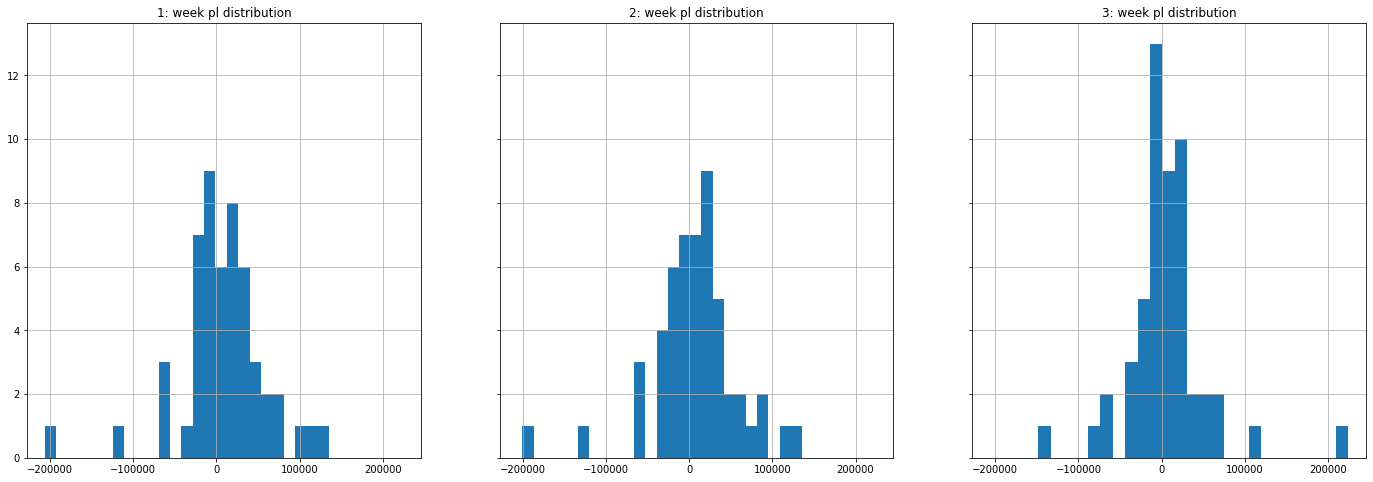

In [ ]:
# 描画領域を定義
fig, axes = plt.subplots(1, len(results), figsize=(8 * len(results), 8), sharex=True, sharey=True)

# 戦略毎に処理
for i, k in enumerate(results.keys()):
    # 描画位置を指定
    ax = axes[i]
    # 分布をプロット
    results[k].week_pl.hist(bins=25, ax=ax)
    # タイトルを設定
    ax.set_title(f"{k}: week pl distribution")
#　描画
plt.show()

　1及び2の戦略は似たような分布をしていることが確認できます。最安値モデルを利用している3は、1や2とは大きく分布が異なっており、分布が狭く運用実績が0近辺に集中していることがわかります。すなわち、3の戦略では、ボラティリティが低い銘柄を中心に採用している可能性があります。

### 2. 週毎の運用実績の統計量

　次に、週毎の運用実績の統計量を算出します。

In [ ]:
# week_plの分布の統計量

# 結合用データ保存
buff = []
# ストラテジー毎に処理
for k in results.keys():
    # week_plの統計量を取得します。
    df = results[k].loc[:, ["week_pl"]].describe().T
    # インデックスを編集してストラテジーのIDにする
    df.index = [k]
    # インデックス名変更
    df.index.name = "strategy_id"
    # 結合用に保存
    buff.append(df)
# 結合して表示
pd.concat(buff)

,count,mean,std,min,25%,50%,75%,max
strategy_id,,,,,,,,
1,52.0,6748.151923,53813.560222,-206099.0,-13608.625,8279.5,36225.825,135435.0
2,52.0,6881.340385,53381.220106,-200310.0,-18729.500,10559.5,29941.125,135733.0
3,52.0,6111.805769,49375.080620,-148206.0,-13086.750,2323.0,22708.250,224107.0


　分布情報を数値で確認すると、先程と同様に1及び2の分布情報が似ていることが確認できます。異なる点として25%分位点を比較すると、1の戦略は2の戦略よりも負けを若干抑えることができている可能性が示唆されます。2の戦略では、1の戦略よりも平均が大きくなっています。結果として、1の戦略は2の戦略よりも収益性は劣るものの、リスクコントロールができている可能性が示唆されています。また、3の戦略の結果は平均が1及び2の戦略より低く、25%及び75%分位点も1及び2の戦略よりも狭い分布となっていることがわかります。

### 3. 週毎の勝率・ペイオフレシオ・シャープレシオ

　他のメトリクスも確認していきましょう。週毎の勝率、ペイオフレシオ、シャープレシオを算出します。

In [ ]:
# 結合用データ保存
buff = []
# 戦略毎に処理
for k in results.keys():
    df_return = results[k]
    # 計算結果保存用
    d = {}
    # 件数
    d["count"] = df_return.shape[0]
    # 勝率
    d["win_ratio"] = (
        df_return.loc[df_return.loc[:, "week_return"] > 0].shape[0] / d["count"]
    )
    # ペイオフレシオ
    d["payoff_ratio"] = df_return.loc[
        df_return.loc[:, "week_return"] > 0, "week_return"
    ].mean() / (
        -1 * df_return.loc[df_return.loc[:, "week_return"] <= 0, "week_return"].mean()
    )
    # シャープレシオ
    d["sharp"] = (
        df_return.loc[:, "week_return"].mean() / df_return.loc[:, "week_return"].std()
    )
    # 平均PL
    d["avgPL"] = df_return.loc[:, "week_pl"].mean()
    # week_plの合計
    d["PL"] = df_return.loc[:, "week_pl"].sum()
    # strategy_idを設定
    df = pd.DataFrame([d], index=[k])
    # インデックス名を指定
    df.index.name = "strategy_id"
    # 結合用に保存
    buff.append(df)
# 結合して表示
pd.concat(buff)

,count,win_ratio,payoff_ratio,sharp,avgPL,PL
strategy_id,,,,,,
1,52,0.557692,1.144253,0.125399,6748.151923,350903.9
2,52,0.576923,1.065494,0.128909,6881.340385,357829.7
3,52,0.519231,1.387056,0.123783,6111.805769,317813.9


　1及び2の戦略の結果はこちらでも似通っています。3の戦略は勝率も低く、運用実績も低いため、今のところ最安値を単体で利用する手法が機能しているようには見えません。

### 4. 週毎に曜日別のリターンをプロット

　週毎の1日目から5日目までのリターンの推移をプロットし、曜日毎に勝ち負けの分布に差異が無いかを確認しています。3章と同じようにseabornのバイオリンプロット( link:https://seaborn.pydata.org/generated/seaborn.violinplot.html )を利用します。

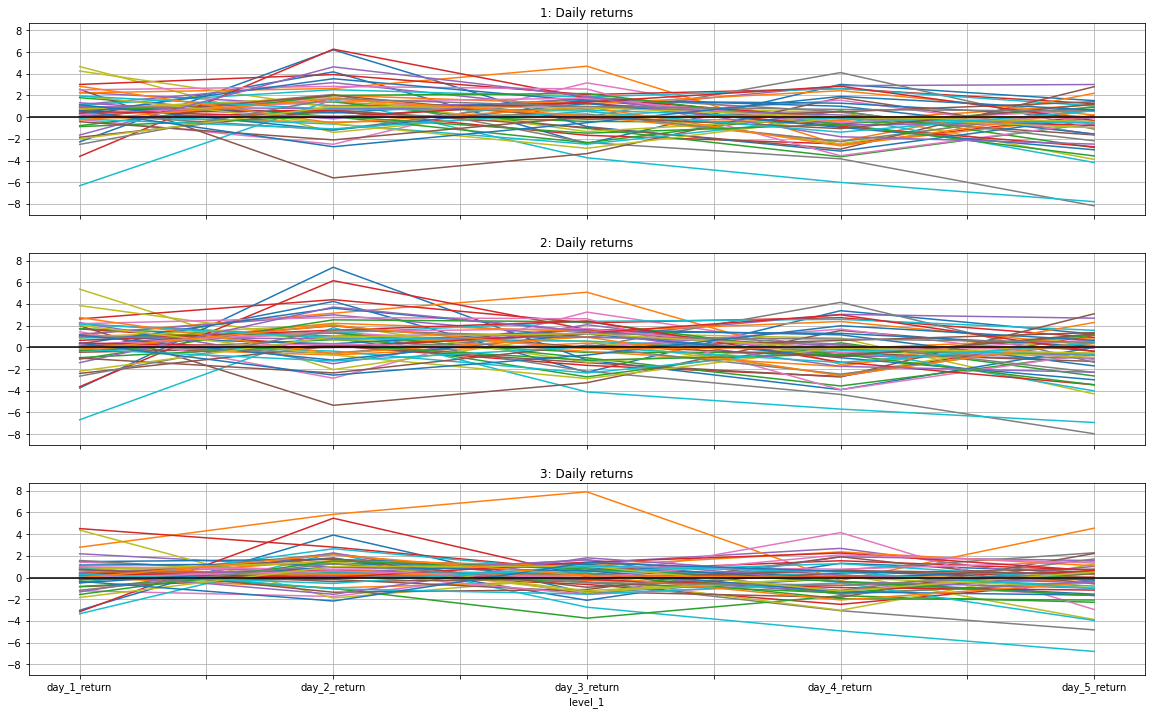

In [ ]:
# 描画領域を定義
fig, axes = plt.subplots(
    len(results), 1, figsize=(20, 4 * len(results)), sharex=True, sharey=True
)

# 描画用データ保存用
dfs_plot = {}

# 戦略毎に処理
for i, k in enumerate(results.keys()):
    # 描画位置を指定
    ax = axes[i]
    # 列を行に変換
    dfs_plot[k] = (
        results[k]
        .set_index("date")
        .loc[
            :,
            [
                "day_1_return",
                "day_2_return",
                "day_3_return",
                "day_4_return",
                "day_5_return",
            ],
        ]
        .stack()
        .to_frame()
        .reset_index()
        .rename(columns={0: "return"})
    )
    # 作業用に変数設定
    df_plot = dfs_plot[k]
    # 各週を列に変換して曜日毎のreturnをプロット
    df_plot.groupby(["level_1", "date"]).first().unstack().plot(ax=ax, legend=False)
    # タイトルを設定
    ax.set_title(f"{k}: Daily returns")
    # リターンが0の位置に基準線を描画
    ax.axhline(y=0, color="black")
    # グリッドを表示
    ax.grid(True)
# 描画
plt.show()

### バイオリンプロット

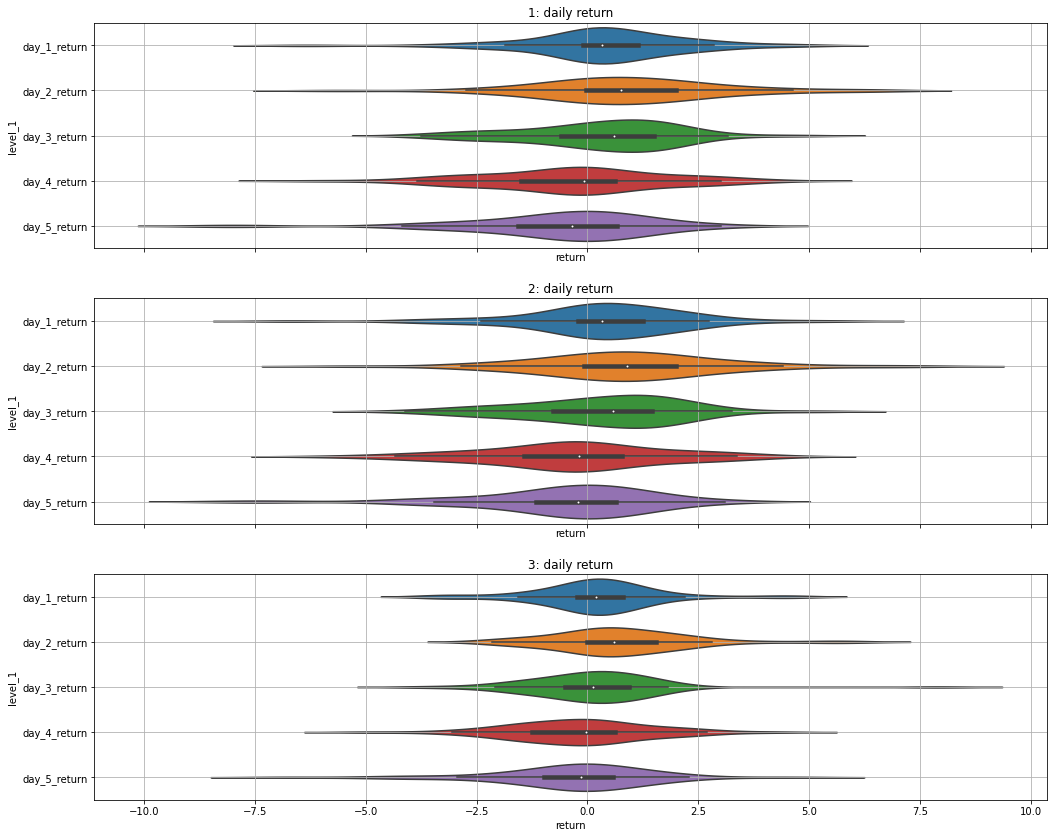

In [ ]:
# 描画領域を定義
fig, axes = plt.subplots(len(results), 1, figsize=(15, 4 * len(results)), sharex=True, sharey=True)

# 戦略毎に処理
for i, k in enumerate(results.keys()):
    # 描画位置を指定
    ax = axes[i]
    # 箱が見やすいように横方向を指定してプロット
    sns.violinplot(x="return", y="level_1", data=dfs_plot[k], ax=ax, orient="h")
    # タイトルを設定
    ax.set_title(f"{k}: daily return")
    # グリッドを表示
    ax.grid(True)
# 文字が重なって読みにくいので間隔調整
fig.tight_layout(pad=2.0)
# 描画
plt.show()

　この結果から1及び2の戦略は、木曜日・金曜日の負けが大きそうなことがわかります。予測モデルを利用する場合、週の後半に負けているのはその予測モデルの効果が後半で薄れている可能性を示唆していることもあるので注意が必要です。このグラフにも若干その傾向が観測されるため、何らかの改善を実施した場合に、この結果がどうなっているかを確認する価値があります。3の戦略は1及び2の戦略と比較すると分布が狭いことが確認できます。

### 6. 週毎のリターンの累積プロット

　次に、取得した収益率の時系列を累積プロットします。まず、比較対象であるベンチマークとして取引対象の全銘柄の平均週次リターンを計算します。

In [ ]:
# 変数名を調整します。
# backtest_priceはユニバースで絞り込み済みです
df_price = backtest_price

In [ ]:
# 週毎に始値と終値を取得
df_wp = (
    # start_dt以降の日付のみ計算
    df_price.loc[df_price.index >= start_dt].sort_values(["Local Code", "EndOfDayQuote Date"])
    # 銘柄コード毎に処理
    .groupby("Local Code")
    # 月曜日スタートで週にリサンプル
    .resample("W-MON", label="left", closed="left")
    # 始値は最初のレコード、終値は最後のレコードを取得
    .agg({"EndOfDayQuote Open": "first", "EndOfDayQuote ExchangeOfficialClose": "last"})
    # マルチインデックスを解除
    .reset_index(level=[0])
)
# Open が 0.0 の銘柄は値段が付かなかった銘柄で、バックテストでは購入対象外であるため除外する
df_wp = df_wp.loc[df_wp.loc[:, "EndOfDayQuote Open"] != 0.0]
# 銘柄毎の週次リターンを計算
df_wp.loc[:, "universe"] = (
    (
        (
            df_wp.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
            / df_wp.loc[:, "EndOfDayQuote Open"]
        )
        - 1
    )
    * 100
)
# ユニバースの週毎のリターンを計算します。
df_universe_return = df_wp.groupby(df_wp.index)["universe"].mean().to_frame()

　ベンチマークとして取引対象の全銘柄の平均週次リターンが準備できたら、今回の取引戦略の結果と一緒にプロットしてみます。

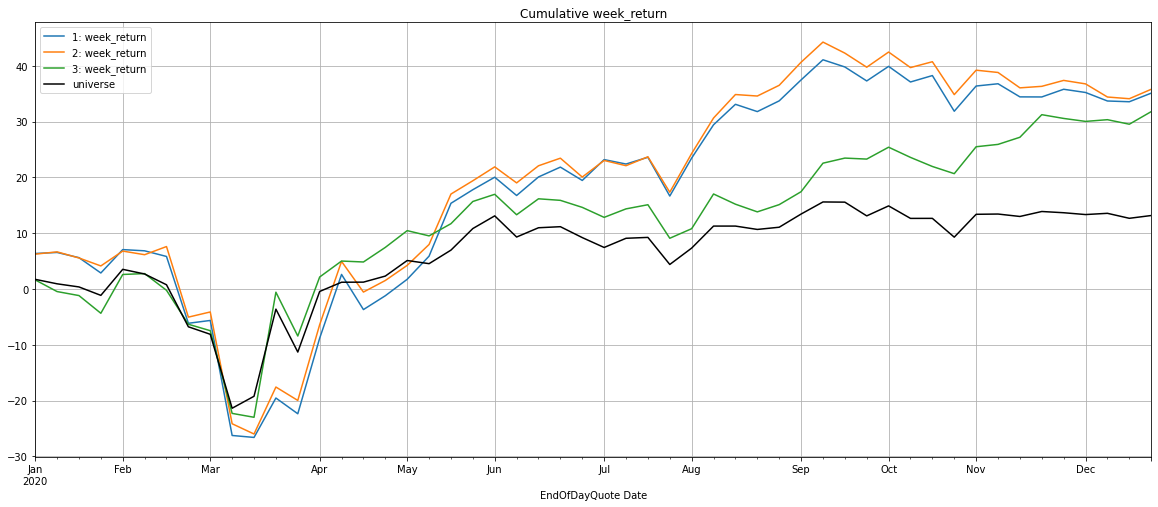

In [ ]:
# 描画領域を定義
fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)

# 戦略毎に処理
for k in results.keys():
    # 描画位置を指定
    ax = axes
    # 戦略別の累積リターンを描画
    results[k].set_index("date").loc[:, ["week_return"]].rename(
        columns={"week_return": f"{k}: week_return"}
    ).cumsum().plot(ax=ax)

# ユニバースの週次リターンの累積をプロット
df_universe_return.cumsum().plot(ax=ax, color="black", label="universe")

# 表示を調整
ax.set_title("Cumulative week_return")
# グリッドを表示
ax.grid(True)
# 描画
plt.show()

　このプロットからは複数の事がわかります。まず1及び2の戦略は想定通り、極めて似通った結果となっています。1の戦略は最安値モデルの結果も足しているため、2の最高値モデルのみを用いたポートフォリオよりもドローダウンが小さいことを期待していましたが、3月の暴落時の結果を見る限り、その効果は観測されていません。これは、3の最安値モデルでも暴落時に下落低減効果が観測できないため、3の戦略では残念ながら3月の暴落の対処にはならなかったようです。

　1及び2の戦略は3月以降の反発で大きく収益を上げています。特にユニバースがほぼフラットになった6月以降も1及び2の戦略は高い収益をあげており、マーケットがフラットな状況でも銘柄選択により収益を上げる力がある可能性が示唆されます。

　また、3の戦略は一見するとユニバースとほぼ同じ収益に見えますが、3月以降ほぼドローダウンが発生しないことは注目に値します。これは低いボラティリティの銘柄を優先的に採用したときなどに見られる現象で、実際に収益曲線が安定していることからも、3の戦略自体もアンサンブルなどのデータとしては有望な可能性があります。

### 7. ユニバースとの散布図

　ユニバースとリターンの散布図をチェックします。ユニバースとリターンの散布図は、マーケットの動きに対してポートフォリオの運用実績がどのように分布するかを確認するために利用します。

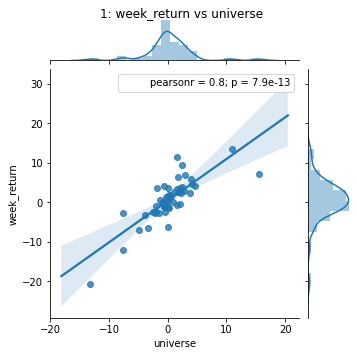

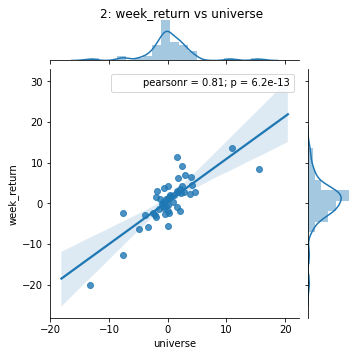

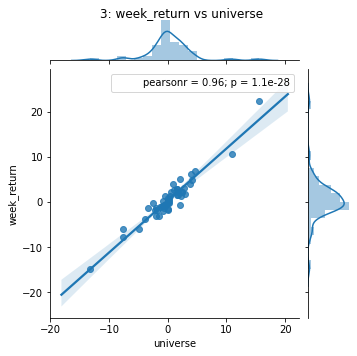

In [ ]:
# 戦略毎に処理
for k in results.keys():
    # 散布図をプロット
    p = sns.jointplot(
        x=df_universe_return.iloc[:, 0],
        y=results[k].loc[:, "week_return"],
        kind="reg",
        height=5,
        stat_func=stats.pearsonr,
    )
    # タイトルを設定
    p.fig.suptitle(f"{k}: week_return vs universe")
    # タイトル表示用に位置を調整
    p.fig.subplots_adjust(top=0.95)
    # 描画
    plt.show()

　1の戦略からはユニバースが0のときも収益を上げる力がある傾向が観測できます。2の戦略の分布は1よりも広く、これは高いボラティリティの銘柄を利用している可能性が示唆されます。3の戦略はユニバースの下落のときは一緒に負けていることが観測できます。もしユニバースが下落しても、下落を抑えることができていれば、3の戦略はリスク回避用のモデルとして理想的な結果でしたが、そのような効果までは観測できませんでした。

### 8. ユニバースに対するベータを計算

　最後にベータを計算しましょう。

In [ ]:
# 結合用に保存
buff = []
# 戦略毎に処理
for k in results.keys():
    # ベータを計算
    res = stats.linregress(df_universe_return.iloc[:,0], results[k].loc[:, "week_return"])
    # 一覧表示用にデータフレームを作成
    df_beta = pd.DataFrame([res.slope], index=[k], columns=["beta"])
    # インデックス名を設定
    df_beta.index.name = "storategy_id"
    # 保存
    buff.append(df_beta)
# 結合して表示
pd.concat(buff)

,beta
storategy_id,
1,1.054601
2,1.048843
3,1.153833


　1及び2の戦略は、1.2近辺の高ベータなストラテジーであることがわかります。3の戦略は低いボラティリティの銘柄をポートフォリオに採用するストラテジー特有の傾向である低いベータ値が観測できています。

### 銘柄毎のデータを使用して分析していきます

　次に、銘柄毎のデータを使用して分析します。ここでは、銘柄毎のデータを使用して分析するために必要な計算を実施しています。

In [ ]:
# 分析用データ保存用
dfs_analyze = {}
# 戦略毎に処理
for i in stocks.keys():
    # 分析用にデータをコピー
    df_analyze = stocks[i].copy()
    # day5に必ず値が存在するように調整します
    df_analyze.loc[:, ["day_1", "day_2", "day_3", "day_4", "day_5"]] = (
        df_analyze.loc[:, ["day_1", "day_2", "day_3", "day_4", "day_5"]]
        .replace(0.0, np.nan)
        .ffill(axis=1)
    )
    # 終値とエントリーの差分を計算
    df_analyze.loc[:, "diff"] = df_analyze.loc[:, ["entry", "day_5"]].diff(axis=1)[
        "day_5"
    ]
    # 損益を計算します
    df_analyze.loc[:, "pl"] = df_analyze.loc[:, "diff"] * df_analyze.loc[:, "actual"]
    # リターンを計算します
    df_analyze.loc[:, "return"] = (
        (df_analyze.loc[:, "day_5"] / df_analyze.loc[:, "entry"]) - 1
    ) * 100
    # infを0.0に変換
    df_analyze = df_analyze.replace(np.inf, 0.0)
    # 処理結果を保存
    dfs_analyze[i] = df_analyze

　分析用データを表示して、うまく計算ができているかを確認します。

In [ ]:
dfs_analyze[2].head(60)

,date,Local Code,budget,n,entry,day_1,day_2,day_3,day_4,day_5,bought,actual,diff,pl,return
0,2020-01-06,3939,50000,0,753.0,775.0,865.0,819.0,806.0,828.0,49698.0,66.0,75.0,4950.0,9.960159
1,2020-01-06,4385,50000,1,2190.0,2142.0,2206.0,2203.0,2175.0,2215.0,48180.0,22.0,25.0,550.0,1.141553
2,2020-01-06,3681,50000,2,654.0,683.0,741.0,711.0,728.0,701.0,49704.0,76.0,47.0,3572.0,7.186544
3,2020-01-06,6080,50000,3,4380.0,4315.0,4465.0,4390.0,4645.0,4685.0,48180.0,11.0,305.0,3355.0,6.963470
4,2020-01-06,4477,50000,4,1715.0,1657.0,1712.0,1725.0,1839.0,1848.0,49735.0,29.0,133.0,3857.0,7.755102
5,2020-01-06,8848,50000,5,350.0,356.0,369.0,377.0,381.0,387.0,49700.0,142.0,37.0,5254.0,10.571429
6,2020-01-06,7003,50000,6,878.0,871.0,911.0,911.0,920.0,939.0,49168.0,56.0,61.0,3416.0,6.947608
7,2020-01-06,3966,50000,7,2248.0,2301.0,2386.0,2327.0,2407.0,2442.0,49456.0,22.0,194.0,4268.0,8.629893
8,2020-01-06,7157,50000,8,719.0,711.0,722.0,721.0,733.0,735.0,49611.0,69.0,16.0,1104.0,2.225313
9,2020-01-06,2929,50000,9,479.0,473.0,553.0,563.0,663.0,693.0,49816.0,104.0,214.0,22256.0,44.676409


### 1. 銘柄毎の運用実績の分布をプロット

　銘柄ごとのリターンの分布をヒストグラムでプロットします。

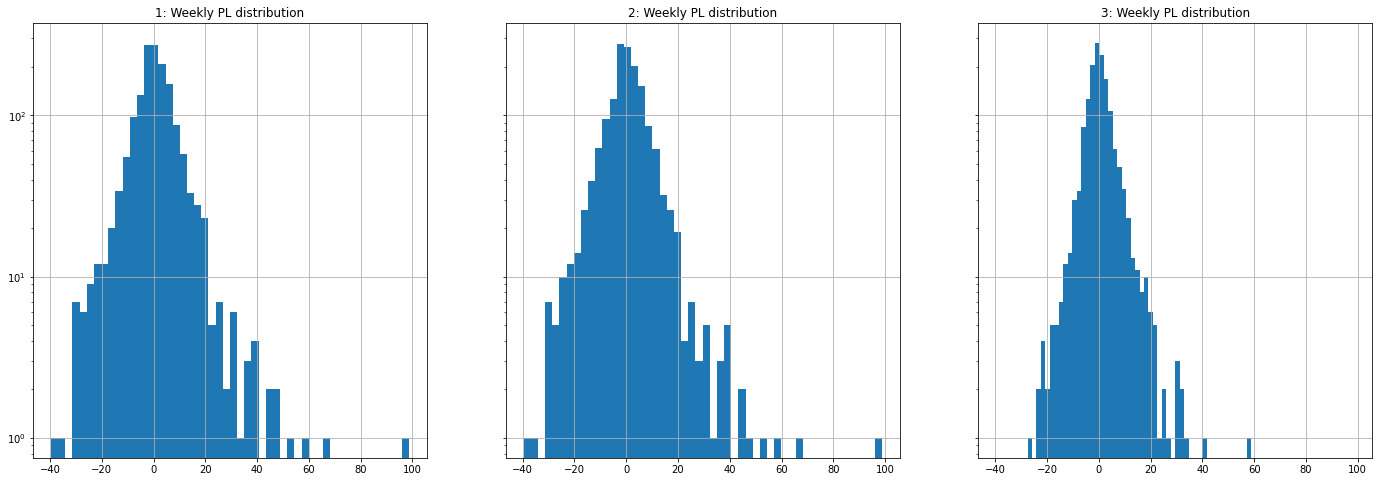

In [ ]:
# 描画領域を定義
fig, axes = plt.subplots(1, len(dfs_analyze), figsize=(8 * len(dfs_analyze), 8), sharex=True, sharey=True)

# 戦略毎に処理
for i, k in enumerate(dfs_analyze.keys()):
    # 描画位置を指定
    ax = axes[i]
    # ヒストグラムをプロット
    dfs_analyze[k].groupby(["date", "Local Code"])["return"].sum().hist(bins=50, log=True, ax=ax)
    # タイトルを設定
    ax.set_title(f"{k}: Weekly PL distribution")
# 描画
plt.show()

　ここからはあまりはっきりとした傾向はわかりませんが、1の戦略の分布が若干右側に広く大勝ちした銘柄を選択できている可能性が示唆されます。3の戦略はやはり銘柄個別で見ても分布が狭く、ボラティリティが低い銘柄を採用しているようです。

In [ ]:
### 2. 週毎の勝ち銘柄率をプロット

　最後に週毎の銘柄の勝率を確認します。

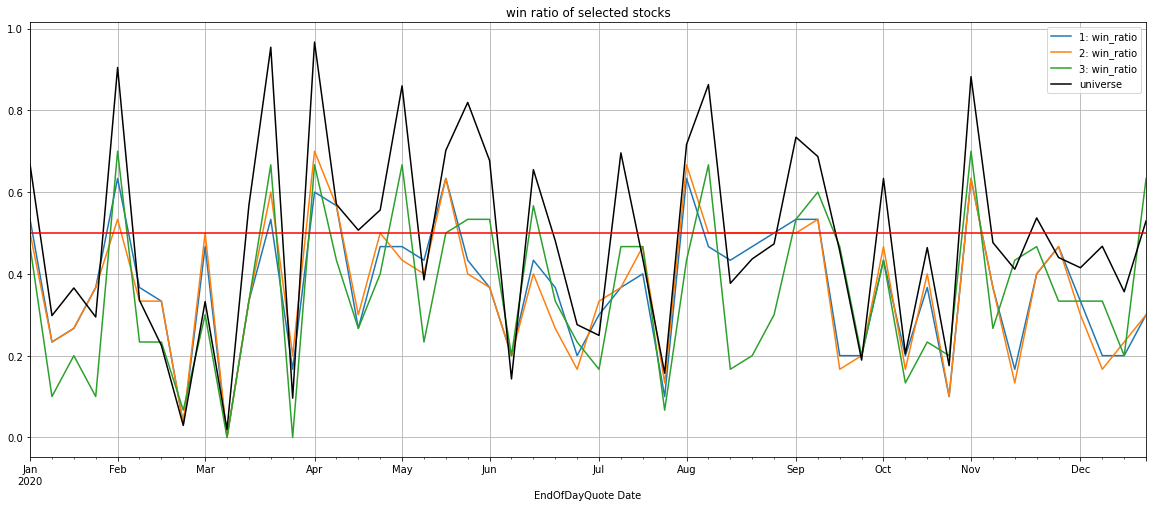

,count,mean,std,min,25%,50%,75%,max
1: win_ratio,52.0,0.365385,0.159924,0.0,0.225000,0.366667,0.466667,0.633333
2: win_ratio,52.0,0.366667,0.166732,0.0,0.233333,0.366667,0.500000,0.700000
3: win_ratio,52.0,0.353846,0.194270,0.0,0.200000,0.333333,0.475000,0.700000


In [ ]:
# 描画領域を定義
fig, ax = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)

# 統計量表示用
buff = []
# 戦略毎に処理
for k in dfs_analyze.keys():
    # 週毎の勝ち銘柄率を計算
    win_ratio = (
        dfs_analyze[k]
        .set_index("date")
        .groupby("date")
        .apply(lambda x: (x.pl > 0).sum() / x.shape[0])
        .to_frame()
        .rename(columns={0: f"{k}: win_ratio"})
    )
    # プロット
    win_ratio.plot(ax=ax)
    # 統計量を保存
    buff.append(win_ratio.describe().T)
# ユニバースの勝ち銘柄率をプロット
df_wp.groupby(df_wp.index).apply(lambda x: (x.universe > 0).sum() / x.shape[0]).rename(
    "universe"
).to_frame().plot(ax=ax, color="black")
# タイトルを設定
ax.set_title("win ratio of selected stocks")
# グリッド表示
ax.grid(True)
# 0.5に基準線を描画
ax.axhline(y=0.5, color="red")
#  描画
plt.show()
# 週毎の勝ち銘柄率の統計量
display(pd.concat(buff))

このプロットからいくつかおもしろいことがわかります。まず、1/2のストラテジーは6月から10月にかけて収益を上げていましたが、この時期に勝率がユニバースよりも高かったわけではないことがわかります。むしろ銘柄単位で見ると勝率はユニバースの平均よりも若干低い事がわかります。つまり、この期間に1/2のストラテジーは勝率で稼いだわけではなく、銘柄ごとのリターンが大きかったことが推測されます。
これはどのような銘柄を選択していたかを調査することによって、どのあたりに収益性の厳選があるかを考えるヒントになります。このような傾向が観測されたらファクター分析などを利用して収益の厳選を確認する作業を実施するなどの発展が考えられます。

## 8. 適時開示情報を使用して特別損失銘柄を除外

　strategy_idの4/5/6にtdnet.csv.gzを使用して特別損失を発表した銘柄を除外する戦略を実装しています。strategy_idに4/5/6を指定してバックテストを実施し、設定した仮説（特別損失開示による株価の下落を回避し、ポートフォリオの利益を向上できるとの仮説）が有効なのかどうかを検証します。

　特別損失を発表した銘柄を除外してポートフォリオを組成します。

In [ ]:
# 戦略毎に処理
for strategy_id in tqdm([4, 5, 6]):
    # ポートフォリオ組成
    str_ret = ScoringService.predict(inputs, start_dt=start_dt, strategy_id=strategy_id)
    # ポートフォリオを保存
    with open(f"chapter03-tutorial-02-backtest-{strategy_id}.csv", mode="w") as f:
        f.write(str_ret)

[+] generate feature



[+] predict



[+] generate feature



[+] predict



[+] generate feature



[+] predict


バックテストを実行します。

In [ ]:
# 戦略毎に処理
for strategy_id in tqdm([4, 5, 6]):
    # ポートフォリオを読み込み
    df_submit = Backtest.load_submit(f"chapter03-tutorial-02-backtest-{strategy_id}.csv")
    # バックテスト実行
    results[strategy_id], stocks[strategy_id] = Backtest.run(df_submit.loc[start_dt:], backtest_codes, backtest_price)

### 改善を試みたバックテスト結果の考察

　ここではまずweek_returnの累積をプロットして効果が出ているかを確認します。

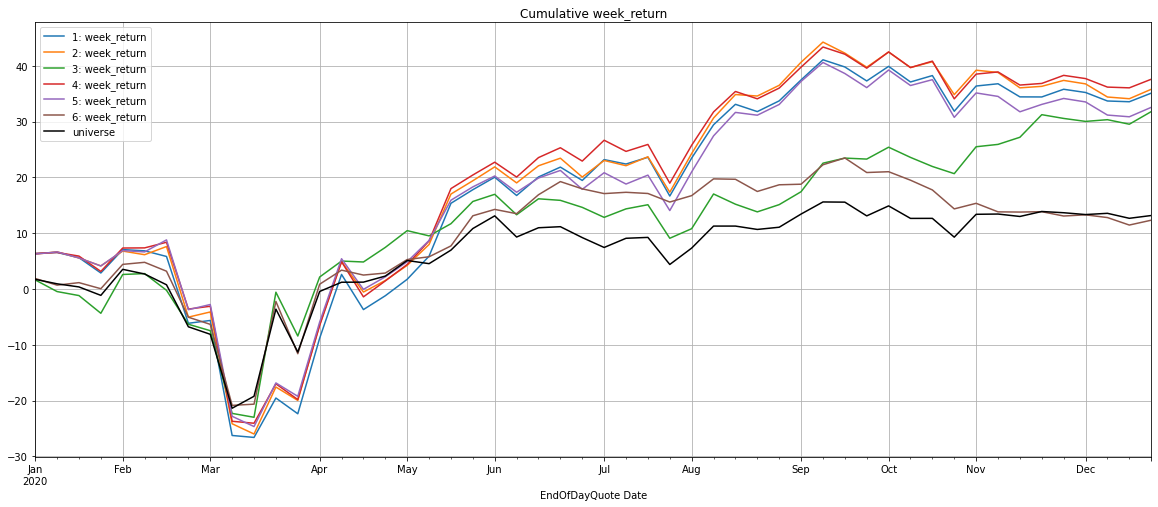

In [ ]:
# 描画領域を定義
fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)

# 戦略毎に処理
for k in results.keys():
    # 描画位置を指定
    ax = axes
    # 戦略別の累積リターンを描画
    results[k].set_index("date").loc[:, ["week_return"]].rename(
        columns={"week_return": f"{k}: week_return"}
    ).cumsum().plot(ax=ax)

# ユニバースの週次リターンの累積をプロット
df_universe_return.cumsum().plot(ax=ax, color="black", label="universe")

# 表示を調整
ax.set_title("Cumulative week_return")
# グリッドを表示
ax.grid(True)
# 描画
plt.show()

　2及び5の戦略に注目すると、特別損失を発表した銘柄を除外するとポートフォリオの利益が上昇することもあることがわかります。ここでは、勝率やシャープレシオ等これまで実施してきた詳細な分析については実施していませんが、実際の戦略の決定には一つの評価指標のみを使用するのではなく、複数の評価指標を使用して総合的に判断することが重要です。前述の評価方法などを参考に各自で実施してみてください。

　また、今回は適時開示情報の特別損失のみを使用していますが、それ以外にも株価に影響を与える開示項目があるかもしれません、上記のように仮説を立てて一つずつ効果を比較しながら検証することが重要になります。

### バックテストの総括

　まず、1及び2の戦略はユニバースと比較して高い収益性を実現できていました。最高値モデルと最安値モデルを足し合わせた1の戦略が、より安定的な収益を上げることを期待していましたが、シャープレシオなどを比較しても2の戦略の方が優れているため、最高値モデルと最安値モデルを足すよりも、現時点では最高値モデルを単体で利用するほうが良い結果が期待できそうです。

　ただし、最高値モデルと最安値モデルの組み合わせ方が悪かった可能性もあります。というのも、2章で作成した予測モデルはあくまでスピアマンの順位相関を意識して作られたため、予測値の幅よりも順位を当てることを意識して設計されています。この場合、予測の幅が必ずしも実際の幅と一致する必要はありませんので、単純に足すよりもscikit-learnライブラリのStandardScaler( https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html )による標準化などを通して、一旦正規化を実施してから足すのがよいのではないかと考えられます。

このようにモデルの構築と利用方法の組み合わせによって銘柄選択の戦略は決まりますので、是非様々な試行錯誤を実施してください。

## 9. パッケージの作成


　このNotebookで実装したScoringServiceと株価変化率の予測モデルのPKLファイル（my_model_label_high_20.pkl, my_model_label_low_20.pkl）をまとめて投稿用ファイルを作成しています。
　提出ファイルのディレクトリ構造は以下の通りです。

JPX_Competition<br>
├── model                  学習済モデルを置くディレクトリ（Chapter02-predictor-create-model.ipynbで作成）<br>
│   └── my_model_label_high_20.pkl<br>
│   └── my_model_label_low_20.pkl<br>
├── src                     　Python のプログラムを置くディレクトリ<br>
│   ├── predictor.py     Chapter02-predictor-create-model.ipynbで作成するモデルのソースコード<br>
└── requirements.txt<br>
└── archive_202104110115.zip　　投稿したファイル<br>

# ライブラリバージョン調整

　本章で利用したモジュールのバージョンを調整するために、requirements.txtに以下を記載して保存します。

